In [2]:
import pandas as pd
import numpy as np
import duckdb
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# 🔹 1. Charger les données
file_path = "../../data/raw/Classeur1.csv"
df = duckdb.query(f"""
    SELECT * FROM read_csv_auto('{file_path}', delim=';', header=True)
""").to_df()

In [4]:
# 🔹 2. Nettoyer les intitulés de poste
def clean_emp_title(title):
    if pd.isnull(title):
        return 'unknown'
    title = title.lower()
    title = re.sub(r"[^a-z\s]", "", title)  # Enlever ponctuation, chiffres
    title = re.sub(r"\b\w{1,2}\b", "", title)  # Enlever mots très courts
    title = re.sub(r"\s+", " ", title)  # Normaliser les espaces
    return title.strip()

df['emp_title_clean'] = df['emp_title'].apply(clean_emp_title)
df['emp_title_clean'] = df['emp_title_clean'].replace('', np.nan)
df['emp_title_clean'] = df['emp_title_clean'].fillna('unknown')

In [ ]:
def classify_job(title):
    if pd.isnull(title) or title.strip() == "":
        return 'unknown'

    title = title.lower()

    # 🎓 Éducation
    if any(x in title for x in ['teacher', 'professor', 'educator', 'instructor', 'principal', 'trainer', 'paraprofessional', 'librarian']):
        return 'education'
    # 🏥 Santé
    if any(x in title for x in ['nurse', 'doctor', 'health', 'medical', 'therapist', 'pharmacist', 'cna', 'lpn', 'physician',
                                 'dental hygienist', 'paramedic', 'caregiver', 'emt', 'lvn', 'dentist', 'kaiser permanente', 
                                 'phlebotomist', 'specialist']):
        return 'health'
    # 🚚 Transport / logistique
    if any(x in title for x in ['driver', 'transport', 'truck', 'transit', 'dispatcher', 'carrier', 'delivery', 'usps', 'ups', 
                                 'postal', 'conductor', 'courier', 'logistics', 'shipping']):
        return 'transport'
    # 💻 Technique / ingénierie / IT
    if any(x in title for x in ['engineer', 'developer', 'it', 'software', 'technician', 'tech', 'machinist', 'maintenance', 
                                 'programmer', 'assembler', 'lineman', 'scientist', 'chemist', 'planner', 'inspector', 'installer', 'estimator']):
        return 'tech'
    # 🏢 Management / cadre
    if any(x in title for x in ['manager', 'director', 'ceo', 'supervisor', 'executive', 'vp', 'president', 'foreman', 
                                 'superintendent', 'cfo', 'lead', 'partner', 'coo', 'management', 'operations']):
        return 'management'
    # 👮 Service public / sécurité / justice / armée
    if any(x in title for x in ['police', 'fire', 'military', 'army', 'officer', 'correctional', 'sergeant', 'deputy', 
                                 'sheriff', 'usaf', 'navy', 'captain', 'law', 'department defense', 'lieutenant', 'detective', 
                                 'nypd', 'government', 'state california', 'federal government', 'dept veterans affairs', 'coast guard',
                                 'social worker', 'air force']):
        return 'public_service'
    # 🛍️ Commerce / relation client / retail
    if any(x in title for x in ['retail', 'sales', 'store', 'customer service', 'cashier', 'server', 'associate', 'walmart', 
                                 'csr', 'clerk', 'bartender', 'agent', 'buyer', 'teller', 'real estate', 'realtor', 'dealer',
                                 'target', 'best buy', 'lowes', 'costco', 'macys', 'home depot', 'the home depot', 'verizon', 'verizon wireless', 'att']):
        return 'retail'
    # 🛠️ Bâtiment / métiers manuels
    if any(x in title for x in ['construction', 'contractor', 'electrician', 'mechanic', 'operator', 'laborer', 'custodian', 
                                 'carpenter', 'assembler', 'painter', 'plumber']):
        return 'construction'
    # 🧮 Finance / droit / audit
    if any(x in title for x in ['accountant', 'finance', 'bank', 'analyst', 'auditor', 'paralegal', 'attorney', 'controller', 
                                 'financial advisor', 'bookkeeper', 'accounting', 'accounts payable', 'accounts receivable', 'billing specialist', 
                                 'loan processor', 'broker', 'morgan chase', 'cpa', 'chase', 'wells fargo']):
        return 'finance'
    # 🧑‍💼 Administratif
    if any(x in title for x in ['admin', 'assistant', 'administrator', 'secretary', 'receptionist', 'coordinator', 'clerical', 
                                 'staff', 'processor', 'mailhandler', 'housekeeper', 'housekeeping']):
        return 'administration'
    # 📢 Conseil / RH / accompagnement
    if any(x in title for x in ['consultant', 'business', 'owner', 'counselor', 'advisor', 'consulting', 'human resources', 'hr']):
        return 'consulting'
    # 🎨 Créatif / Design / Marketing
    if any(x in title for x in ['designer', 'marketing', 'communications', 'producer', 'stylist']):
        return 'creative'
    # 🧱 Production / Industrie / Opérations
    if any(x in title for x in ['warehouse', 'production', 'inspector', 'cook', 'chef', 'material handler', 'assembler', 
                                 'stocker', 'assembler', 'assembly']):
        return 'manual_work'
    # ✝️ Clergé / religion
    if 'pastor' in title:
        return 'religious'
    # 🎓 Étudiant
    if 'student' in title:
        return 'student'
    # 🚫 Sans emploi
    if 'unemployed' in title:
        return 'unemployed'
    # ❓ Inconnu explicite
    if 'unknown' in title:
        return 'unknown'
    return 'other'

df['job_category'] = df['emp_title_clean'].apply(classify_job)
df['job_category_encoded'] = df['job_category'].astype('category').cat.codes

# 👇 Vérifier la distribution
print(df['job_category'].value_counts())

job_category
other             109813
management         71124
tech               57071
health             26815
unknown            26703
retail             22165
finance            16374
public_service     13096
transport          12127
education          10439
administration      9940
construction        8255
consulting          7739
creative            2097
manual_work         1893
religious            287
student               91
unemployed             1
Name: count, dtype: int64


In [6]:
# Récupérer tous les intitulés actuellement classés comme 'other'
other_titles = df[df['job_category'] == 'other']['emp_title_clean']

# Lister tous les intitulés uniques avec leur fréquence d'apparition
all_other_titles_freq = other_titles.value_counts()

# Export ou affichage
print("🔍 Nombre total d’intitulés uniques classés comme 'other' :", len(all_other_titles_freq))
print("\n🔎 Tous les intitulés à catégoriser :")
print(all_other_titles_freq)

all_other_titles_freq.to_csv("../../data/processed/other_job_titles.csv", header=True)


🔍 Nombre total d’intitulés uniques classés comme 'other' : 65587

🔎 Tous les intitulés à catégoriser :
emp_title_clean
welder                      274
pilot                       219
investigator                170
ibm                         164
lockheed martin             159
                           ... 
armored car guard             1
yakima prosecutor office      1
reliable auto repair          1
specialty group inc           1
cristo rey high school        1
Name: count, Length: 65587, dtype: int64


In [7]:
# 🔹 4. Statistiques avant/après
top_raw = df['emp_title'].value_counts().head(20)
top_clean = df['emp_title_clean'].value_counts().head(20)
top_cat = df['emp_category'].value_counts()

KeyError: 'emp_category'

C:\Users\Pierre\AppData\Local\Temp\ipykernel_72232\2496662274.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_raw.index, x=top_raw.values, ax=axes[0], palette="magma")
C:\Users\Pierre\AppData\Local\Temp\ipykernel_72232\2496662274.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_clean.index, x=top_clean.values, ax=axes[1], palette="viridis")


NameError: name 'top_cat' is not defined

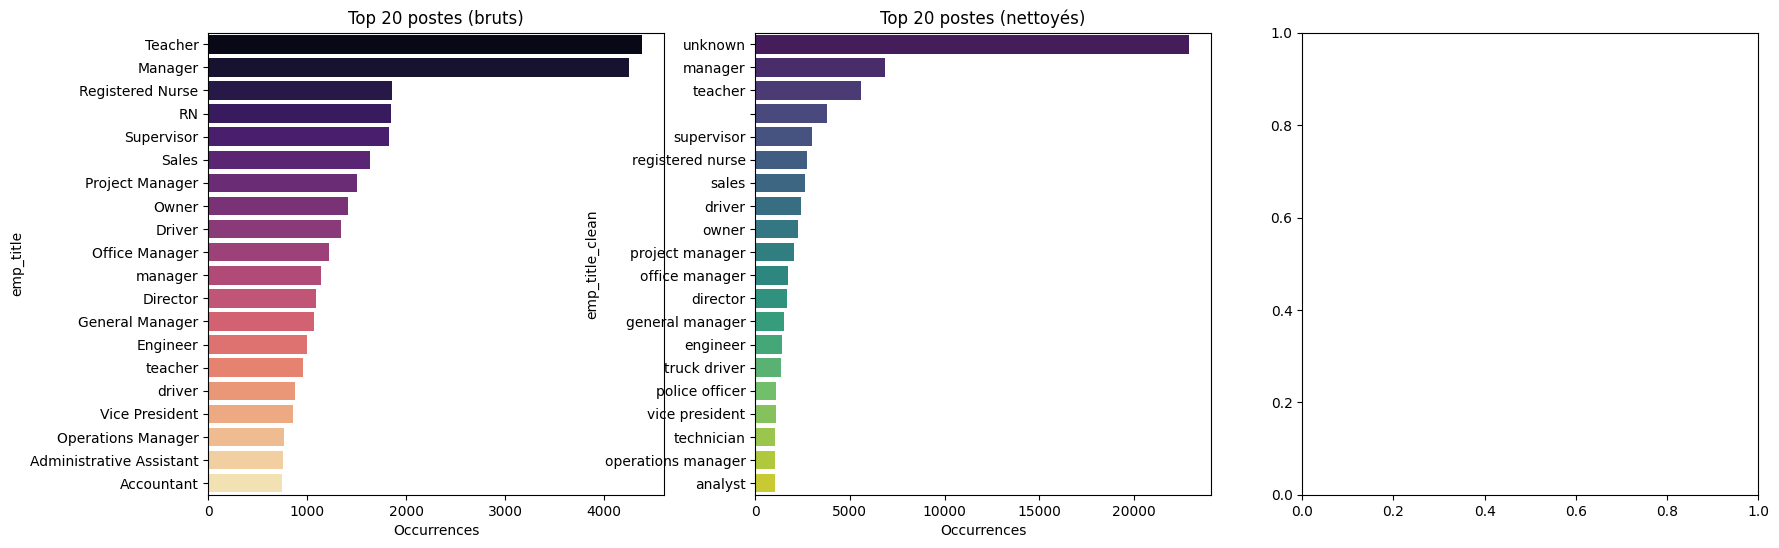

In [6]:
# 🔹 5. Visualisation
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.barplot(y=top_raw.index, x=top_raw.values, ax=axes[0], palette="magma")
axes[0].set_title("Top 20 postes (bruts)")
axes[0].set_xlabel("Occurrences")

sns.barplot(y=top_clean.index, x=top_clean.values, ax=axes[1], palette="viridis")
axes[1].set_title("Top 20 postes (nettoyés)")
axes[1].set_xlabel("Occurrences")

sns.barplot(y=top_cat.index, x=top_cat.values, ax=axes[2], palette="Set2")
axes[2].set_title("Nombre de postes par catégorie")
axes[2].set_xlabel("Occurrences")

plt.tight_layout()
plt.show()